In [1]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
import statsmodels.api as sm

from nba_api.stats.endpoints import leaguegamelog
from nba_api.stats.endpoints import playbyplayv2
from nba_api.stats.endpoints import boxscoresummaryv2

# Use this endpoint to add historical data (i.e, W/L record, season stats)
# to feature space.
# from nba_api.stats.endpoints import teamgamelog 

from mar_designs import tidy_axes

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

facecolor = "#F7F5F2"
figsize=(11,6)
subplotFigsize=(28,6)
titlesize=16
labelsize=14

## Get game IDs for the 2023-2024 season and win/lose label

In [3]:
# Get team-level logs for the current or recent season
gamelog = leaguegamelog.LeagueGameLog(season='2023-24')
game_labels_df = gamelog.get_data_frames()[0]

# Keep ID, team name,  and win/lose label
game_labels_df = game_labels_df[["GAME_ID", "TEAM_NAME", "WL"]]

# Shorthand team name to just the name (not the city)
game_labels_df["TEAM_NAME"] = game_labels_df["TEAM_NAME"].apply(lambda s: "Trail Blazers" if "Trail" in s else s.split(" ")[-1])  # This gets the nickname. 

game_labels_df.to_csv("../data/module3_data/labels.csv")
game_labels_df.head(3)

,GAME_ID,TEAM_NAME,WL
0,0022300061,Lakers,L
1,0022300062,Warriors,L
2,0022300062,Suns,W


In [4]:
# Map EVENTMSGTYPE per API documentation
# Remove non-player events
event_type_dict = {
    1: "FIELD_GOAL_MADE",
    2: "FIELD_GOAL_MISSED",
    3: "FREE_THROW",
    4: "REBOUND",
    5: "TURNOVER",
    6: "FOUL",
    7: "VIOLATION",
    8: "SUBSTITUTION",
    # 9: "TIMEOUT",
    # 10: "JUMP_BALL",
    11: "EJECTION",
    # 12: "PERIOD_BEGIN",
    # 13: "PERIOD_END"
}

In [5]:
# Run this block to call API and generate dataset

runThisCode = False
if runThisCode:
    game_ids = game_labels_df["GAME_ID"].unique()
    half_stats_list = []
    for game_id in game_ids:  
        pbp = playbyplayv2.PlayByPlayV2(game_id=game_id)
        pbp_df = pbp.get_data_frames()[0]

        # Limit to the first half
        pbp_df = pbp_df[pbp_df["PERIOD"] <= 2]

        pbp_df["EVENTMSGTYPE"] = pbp_df["EVENTMSGTYPE"].map(event_type_dict)

        # Drop rows with 10, 12, 13 in the message type
        # Drop rows with None in PLAYER1_TEAM_NICKNAME -- e.g., team rebounds -- it's hard
        # to tell what team performed a rebound if PLAYER1_TEAM_NICKNAME isn't specified
        pbp_df = pbp_df.dropna(subset=["EVENTMSGTYPE", "PLAYER1_TEAM_NICKNAME"])

        # Only keep 3 rows from original playbyplay df
        pbp_df_reduced = pbp_df[["GAME_ID", "EVENTMSGTYPE", "PLAYER1_TEAM_NICKNAME"]]

        # Get team names -- use them and game_ID to get label
        team1Name, team2Name = pbp_df_reduced["PLAYER1_TEAM_NICKNAME"].unique()
        team1Label = game_labels_df[(game_labels_df["GAME_ID"]==game_id)&(game_labels_df["TEAM_NAME"]==team1Name)]["WL"].to_list()[0]
        team2Label = game_labels_df[(game_labels_df["GAME_ID"]==game_id)&(game_labels_df["TEAM_NAME"]==team2Name)]["WL"].to_list()[0]
        
        # Break reduced dataframe into two dataframes; one per team. Get summary of each stat with value_counts.
        team1_df = pbp_df_reduced[pbp_df_reduced["PLAYER1_TEAM_NICKNAME"] == team1Name]
        team1_stats_df =  team1_df["EVENTMSGTYPE"].value_counts().reindex(event_type_dict.values(), fill_value=0)
        team2_df = pbp_df_reduced[pbp_df_reduced["PLAYER1_TEAM_NICKNAME"] == team2Name]
        team2_stats_df = team2_df["EVENTMSGTYPE"].value_counts().reindex(event_type_dict.values(), fill_value=0)

        # Get the difference in stats for each team, rename the columns, and append to the final team dataframe
        statsNoDiff = ["VIOLATION", "SUBSTITUTION", "EJECTION"] # don't create diff measurements of these metrics
        team1_stat_diff = team1_stats_df - team2_stats_df
        team1_stat_diff = team1_stat_diff.drop(labels=statsNoDiff)
        team2_stat_diff = -1*team1_stat_diff

        diffColNames = [f"{col}_DIFF" for col in team1_stat_diff.index]
        team1_stat_diff.index = diffColNames
        team2_stat_diff.index = diffColNames

        # Merge the stats and stat difference series objects
        team1_final_ser = pd.concat([team1_stats_df, team1_stat_diff])
        team2_final_ser = pd.concat([team2_stats_df, team2_stat_diff])

        # Convert final series (that contain stats and some differences)
        # to list and append team name and game_id
        team1_stats_list = team1_final_ser.to_list()
        team1_stats_list.extend([team1Name, game_id, team1Label])
        team2_stats_list = team2_final_ser.to_list()
        team2_stats_list.extend([team2Name, game_id, team2Label])

        # Add to final results dataframe
        half_stats_list.append(team1_stats_list)
        half_stats_list.append(team2_stats_list)

        time.sleep(4)        

In [6]:
# Save or read in data
dataPath = "../data/module3_data/cleaned_labeled_data.csv"
if runThisCode:
    colNames = list(event_type_dict.values()) + diffColNames
    colNames.extend(["TEAM_NAME", "GAME_ID", "WL"])
    df = pd.DataFrame(half_stats_list, columns=colNames)
    df.to_csv(dataPath)
else:
    df = pd.read_csv(dataPath, index_col=0)

df.head(3)

,FIELD_GOAL_MADE,FIELD_GOAL_MISSED,FREE_THROW,REBOUND,TURNOVER,FOUL,VIOLATION,SUBSTITUTION,EJECTION,FIELD_GOAL_MADE_DIFF,FIELD_GOAL_MISSED_DIFF,FREE_THROW_DIFF,REBOUND_DIFF,TURNOVER_DIFF,FOUL_DIFF,TEAM_NAME,GAME_ID,WL
0,18,40,6,24,4,15,0,14,0,-4,17,-9,-9,-5,8,Warriors,22300062,L
1,22,23,15,33,9,7,1,13,0,4,-17,9,9,5,-8,Suns,22300062,W
2,22,27,6,24,5,12,1,13,0,-2,3,-5,0,0,9,Lakers,22300061,L


---
## Begin modeling

In [7]:
# Drop labels to have a df_unlabled for each model
df_unlabeled = df.drop(columns=["TEAM_NAME", "GAME_ID", "WL"], axis=0)
y = df["WL"].map({"W":1, "L":0}).values  # serve as the labels for all train_test_split functions

# df_unlabeled = df[["FIELD_GOAL_MADE_DIFF", "FIELD_GOAL_MISSED_DIFF"]]#, "FREE_THROW", "FIELD_GOAL_MADE", "FOUL_DIFF", "TURNOVER_DIFF"]]

# REGRESSION TAB
## Run PCA and logistic regression
### Logistic regression can take all of the quantitative variables from the unlabeled dataset. Effectively, this only removes the `TEAM_NAME` and `GAME_ID` -- the latter of which was just used for merging the labels onto the final dataset and isn't a feature at all. 

In [8]:
# Drop labels and split data into training and testing for logistic regression and PCA
X = df_unlabeled.values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [9]:
# PCA object on scaled data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# PCA 1 component
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X_train_scaled)

In [10]:
# Perform logistic regression

# Add a constant for the intercept term
X_train_const = sm.add_constant(X_pca)
logit_model = sm.Logit(y_train, X_train_const)
result = logit_model.fit()

# Summary
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.565710
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1107
Model:                          Logit   Df Residuals:                     1105
Method:                           MLE   Df Model:                            1
Date:                Mon, 07 Apr 2025   Pseudo R-squ.:                  0.1838
Time:                        13:10:21   Log-Likelihood:                -626.24
converged:                       True   LL-Null:                       -767.31
Covariance Type:            nonrobust   LLR p-value:                 2.570e-63
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.069     -0.033      0.973      -0.137       0.132
x1             0.7280      0.

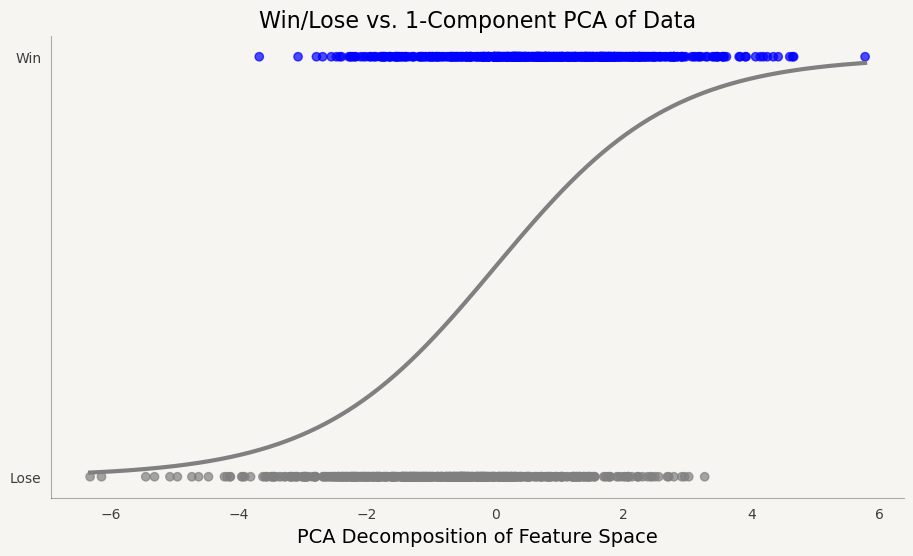

In [11]:
# Scatter plot of binary data
fig, ax = plt.subplots(figsize=figsize)
ax.scatter(X_train_const[:,1], y_train, alpha=0.7, c=["blue" if idx == 1 else "grey" for idx in y_train])

# Make a phony x axis to plot a smooth logit curve
phony_x = np.linspace(X_train_const[:,1].min(), X_train_const[:,1].max(), 500)  # 500 points for smoothness
phony_X_df = pd.DataFrame({'X_pca': phony_x})
phony_X_df = sm.add_constant(phony_X_df)
phony_predictions = result.predict(phony_X_df)
ax.plot(phony_x, phony_predictions, '-', color='grey',linewidth=3)

tidy_axes(ax)
fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)
ax.set_title("Win/Lose vs. 1-Component PCA of Data", fontsize=titlesize)
ax.set_xlabel("PCA Decomposition of Feature Space", fontsize=labelsize)

ax.set_yticks([0,1], ["Lose", "Win"])
plt.savefig("../images/module3_images/WL_vs_pca.png")
plt.show()

In [12]:
# Test accuracy, error rate, and confusion matrix measurements
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)    # NOTE THIS IS TRANSFORMING X_test_scaled by same transformation as test data
X_test_const = sm.add_constant(X_test_pca)

y_res = result.predict(X_test_const)

binaryMask = y_res >= 0.5

y_res[binaryMask] = 1
y_res[~binaryMask] = 0

Accuracy is: 0.7003610108303249
Error rate is 0.29963898916967513


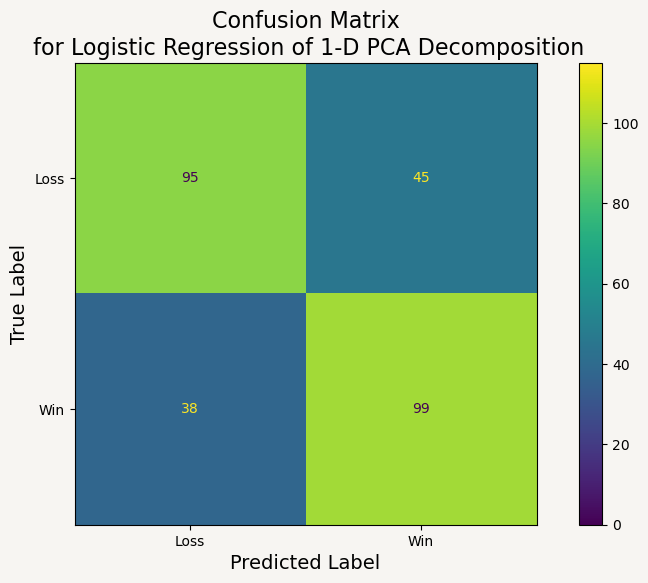

In [13]:
# Show confusion matrix for PCA data
fig, ax = plt.subplots(figsize=figsize)
cm = confusion_matrix(y_test, y_res)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Loss", "Win"])
disp.plot(ax=ax)#, colorbar=False)


acc = np.diagonal(cm).sum()/np.sum(cm)
err = 1 - acc

print(f"Accuracy is: {acc}")
print(f"Error rate is {err}")

im = ax.images[0]
im.set_clim(vmin=0, vmax=115)
fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)
ax.set_xlabel("Predicted Label", fontsize=labelsize)
ax.set_ylabel("True Label", fontsize=labelsize)
ax.set_title("Confusion Matrix\n for Logistic Regression of 1-D PCA Decomposition", fontsize=titlesize)
plt.savefig("../images/module3_images/confusion_matrix_logistic_regression_pca.png")

## Run logistic regression on the same dataset WITHOUT PCA

Optimization terminated successfully.
         Current function value: 0.525075
         Iterations 6

Accuracy is: 0.7292418772563177
Error rate is 0.2707581227436823


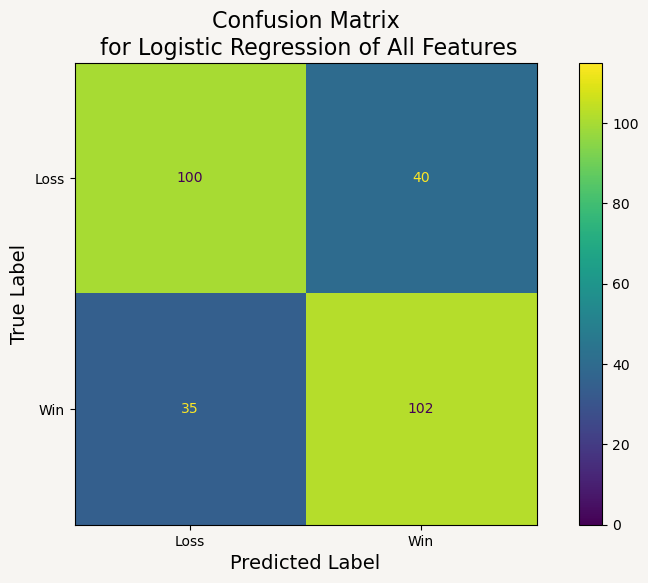

In [14]:
# Add a constant for the intercept term
X_train_const = sm.add_constant(X_train)
logit_model = sm.Logit(y_train, X_train_const)
result = logit_model.fit()

# Evaluate the results
X_test_const = sm.add_constant(X_test)
y_pred = result.predict(X_test_const)

# Mask to binary
binaryMask = y_pred >= 0.5
y_pred[binaryMask] = 1
y_pred[~binaryMask] = 0



# Show confusion matrix for non-PCA data
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Loss", "Win"])

fig, ax = plt.subplots(figsize=figsize)
disp.plot(ax=ax)

acc = np.diagonal(cm).sum()/np.sum(cm)
err = 1 - acc


im = ax.images[0]
im.set_clim(vmin=0, vmax=115)
fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)
ax.set_xlabel("Predicted Label", fontsize=labelsize)
ax.set_ylabel("True Label", fontsize=labelsize)
ax.set_title("Confusion Matrix\n for Logistic Regression of All Features", fontsize=titlesize)
plt.savefig("../images/module3_images/confusion_matrix_logistic_regression_all.png")

print()
print(f"Accuracy is: {acc}")
print(f"Error rate is {err}")

---
## Now implement Multinomial Naive Bayes
### Multinomial Naive Bayes only works on non-negative count data. Thus, I will remove all of the `_DIFF` features in the dataset.
### I will also add a `FGA` feature to the dataset to account for how many total field goals have been attempted - this may capture some of the information that the `_DIFF` features provided.

In [15]:
# Drop diff columns in data
df_multinomial = df_unlabeled[[col for col in df_unlabeled.keys() if "DIFF" not in col]].copy()

# Create a new column for field goal attempts
df_multinomial["FGA"] = df_multinomial["FIELD_GOAL_MADE"] + df_multinomial["FIELD_GOAL_MISSED"] 

df_multinomial.to_csv("../data/module3_data/multinomial_bayes_data.csv")
df_multinomial.head()

,FIELD_GOAL_MADE,FIELD_GOAL_MISSED,FREE_THROW,REBOUND,TURNOVER,FOUL,VIOLATION,SUBSTITUTION,EJECTION,FGA
0,18,40,6,24,4,15,0,14,0,58
1,22,23,15,33,9,7,1,13,0,45
2,22,27,6,24,5,12,1,13,0,49
3,24,24,11,24,5,3,0,11,0,48
4,22,20,17,25,7,7,0,14,0,42


In [16]:
# Test train split for Multinomial NB
X = df_multinomial.values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [17]:
# Train model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()


Accuracy is: 0.6823104693140795
Error rate is 0.31768953068592054


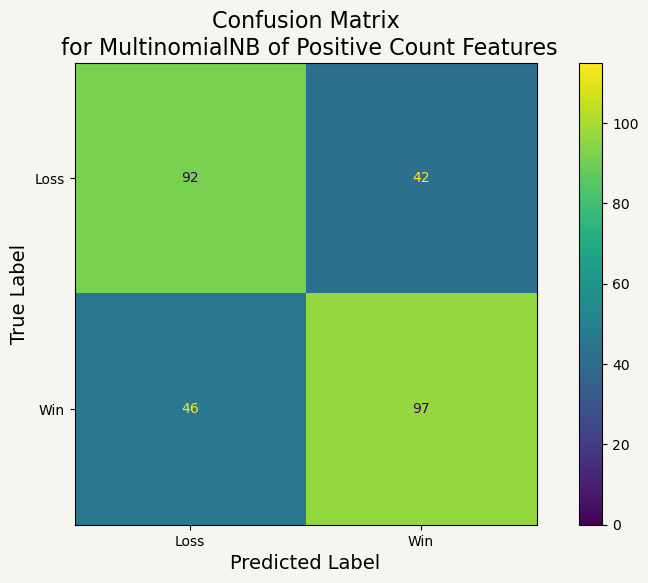

In [18]:
# Test the model
y_pred = nb_model.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Loss", "Win"])

fig, ax = plt.subplots(figsize=figsize)
disp.plot(ax=ax)

acc = np.diagonal(cm).sum()/np.sum(cm)
err = 1 - acc

im = ax.images[0]
im.set_clim(vmin=0, vmax=115)
fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)
ax.set_xlabel("Predicted Label", fontsize=labelsize)
ax.set_ylabel("True Label", fontsize=labelsize)
ax.set_title("Confusion Matrix\n for MultinomialNB of Positive Count Features", fontsize=titlesize)
plt.savefig("../images/module3_images/confusion_matrix_multinomialNB.png")

print()
print(f"Accuracy is: {acc}")
print(f"Error rate is {err}")

---
# NAIVE BAYES TAB
## Now, implement Bernoulli Naive Bayes. 
### This form of Naive Bayes requires a feature space of 0's and 1's and allows only for binary classification. To handle this, I'll take my unlabled data in `df_unlabeled`, dropp all but the `_DIFF` columns, and conver them to binary based on their sign.

### Note that by setting all values of DIFF to 1 if there value is positive and 0 otherwise will result in edge cases where the difference was actually zero not being modified by this transformation. Thus, after the transformation, there are two types of zeros in reality but not differentiated by the model: the first zero, transformed from a negative number represents a deficit in that stat for the game at halftime. The other zero represents a true no-difference between that team and the other. Thus, features with a lot of trie no-difference-zeros may be devalued in importance in the model's training because it can't distinguish between this case and a team's deficit in this stat. 

### Furthermore, this backs up to the inherit limitation of Bernoulli Naive Bayes -- it does not distinguish extremely positive stat differences from just slightly positive stat differences. For example, a team with 10 more `FIELD_GOAL_MADE_DIFF` will be weighted the same way as a team with just a value of 1 in this column. Thus, Bernoulli Naive Bayes may not be the best model for data that isn't inherently binary in the feature space. 

In [19]:
# Only get DIFF columns
df_bernoulli = df_unlabeled[[col.strip() for col in df_unlabeled.keys() if "DIFF" in col]].copy()

# Convert to 1's and 0's per the above described reasoning
df_bernoulli = df_bernoulli.applymap(lambda x: 1 if x>0 else 0)
df_bernoulli.to_csv("../data/module3_data/bernoulli_bayes_data.csv")
df_bernoulli.head(3)

,FIELD_GOAL_MADE_DIFF,FIELD_GOAL_MISSED_DIFF,FREE_THROW_DIFF,REBOUND_DIFF,TURNOVER_DIFF,FOUL_DIFF
0,0,1,0,0,0,1
1,1,0,1,1,1,0
2,0,1,0,0,0,1


In [20]:
# Break into testing and training
X = df_bernoulli.values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [21]:
# Implement model
clf = BernoulliNB()

# Train
clf.fit(X_train, y_train)

# Predict with testing
y_pred = clf.predict(X_test)


Accuracy is: 0.776173285198556
Error rate is 0.223826714801444


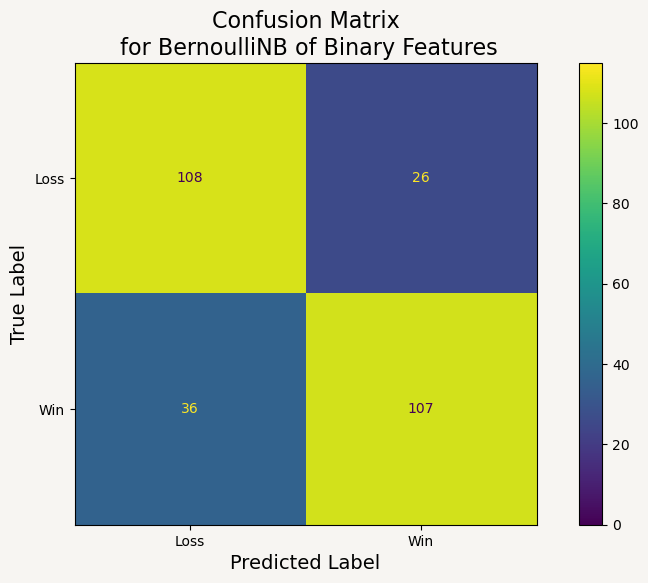

In [22]:
# Confusion matrix
fig, ax = plt.subplots(figsize=figsize)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Loss", "Win"])
disp.plot(ax=ax)

acc = np.diagonal(cm).sum()/np.sum(cm)
err = 1 - acc

im = ax.images[0]
im.set_clim(vmin=0, vmax=115)
fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)
ax.set_xlabel("Predicted Label", fontsize=labelsize)
ax.set_ylabel("True Label", fontsize=labelsize)
ax.set_title("Confusion Matrix\n for BernoulliNB of Binary Features", fontsize=titlesize)
plt.savefig("../images/module3_images/confusion_matrix_bernoulliNB.png")

print()
print(f"Accuracy is: {acc}")
print(f"Error rate is {err}")

### It seems that even with the limitaitons of Bernoulli's "double zeros" in the feature space, this model might actually have the highest accuracy so far. My explanation for this is that it uses the `_DIFF` features -- which seem to be the most important for deciding the outcome of a game at halftime because these stats reflect the relative importance of a team's performance in the game instead of absolute statistical values across many games.

### Also, that said, we might think that having a 0 (i.e, less than the other team) in shots missed would correlate higher with winning. SO, this doesn't just assume that 0's in feature space mean 0's in label classification. It's still performing the same Naive Bayes and looks at unique stats of feature space and their relationship to classification and accounts that some features will have a positive (and others a negative) correlation to the classification . 

---
## Now to implement Gaussian Naive Bayes -- this method of NB prefers continuious data and assumes it's normally distributed. So, instead of using raw count or binary data like the previous implementations, I'll feature engineer the dataset to be percentages of total stats that occured in the game.

In [23]:
labelCols = ["TEAM_NAME", "GAME_ID", "WL"]
game_ids = df["GAME_ID"].unique()
percentResults = []
for game_id in game_ids:
    
    # Get a df that contains the two games for the game_id
    game_df = df[df["GAME_ID"] == game_id]
    
    if len(game_df) != 2:
        print(f"Game ID: {game_id} only has one game in dataset. API call must have failed higher up in notebook.")
        continue
    
    # Drop the `_DIFF` columns
    absolute_stats_per_game = game_df[[col for col in game_df.keys() if "DIFF" not in col]]
    
    # Drop the labels, store them to the side.
    absolute_stats_no_labels = absolute_stats_per_game.drop(columns=labelCols)
    dropped_label_cols = absolute_stats_per_game[labelCols]
    
    # Get team stats and labels
    
    team1_index = absolute_stats_no_labels.index[0]
    team2_index = absolute_stats_no_labels.index[1]
    team1_stats = absolute_stats_no_labels.loc[team1_index]
    team2_stats = absolute_stats_no_labels.loc[team2_index]
    team1_labels = dropped_label_cols.loc[team1_index]
    team2_labels = dropped_label_cols.loc[team2_index]
    
    # Create a total stat row
    total_stats = team1_stats + team2_stats
    
    # Get percentage of total stats for each team
    team1_percents = team1_stats/total_stats
    team2_percents = team2_stats/total_stats
    
    team1_percents_list = team1_percents.to_list() + team1_labels.to_list()
    team2_percents_list = team2_percents.to_list() + team2_labels.to_list()
    
    percentResults.append(team1_percents_list)
    percentResults.append(team2_percents_list)

df_gaussian = pd.DataFrame(percentResults, columns=absolute_stats_per_game.keys())

In [24]:
# Drop labels, again, and also drop violation and ejection since there must have been a lot of divide by 0
# in the percent calculations
df_gaussian.info()

df_gaussian = df_gaussian.drop(columns=["VIOLATION", "EJECTION", "TEAM_NAME", "GAME_ID", "WL"])
df_gaussian.to_csv("../data/module3_data/gaussian_bayes_data.csv")
df_gaussian.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384 entries, 0 to 1383
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   FIELD_GOAL_MADE    1384 non-null   float64
 1   FIELD_GOAL_MISSED  1384 non-null   float64
 2   FREE_THROW         1384 non-null   float64
 3   REBOUND            1384 non-null   float64
 4   TURNOVER           1384 non-null   float64
 5   FOUL               1384 non-null   float64
 6   VIOLATION          694 non-null    float64
 7   SUBSTITUTION       1384 non-null   float64
 8   EJECTION           12 non-null     float64
 9   TEAM_NAME          1384 non-null   object 
 10  GAME_ID            1384 non-null   int64  
 11  WL                 1384 non-null   object 
dtypes: float64(9), int64(1), object(2)
memory usage: 129.9+ KB


,FIELD_GOAL_MADE,FIELD_GOAL_MISSED,FREE_THROW,REBOUND,TURNOVER,FOUL,SUBSTITUTION
0,0.450000,0.634921,0.285714,0.421053,0.307692,0.681818,0.518519
1,0.550000,0.365079,0.714286,0.578947,0.692308,0.318182,0.481481
2,0.478261,0.529412,0.352941,0.500000,0.500000,0.800000,0.541667


In [25]:
df_gaussian.sum()

FIELD_GOAL_MADE      692.0
FIELD_GOAL_MISSED    692.0
FREE_THROW           692.0
REBOUND              692.0
TURNOVER             692.0
FOUL                 692.0
SUBSTITUTION         692.0
dtype: float64

1384.0


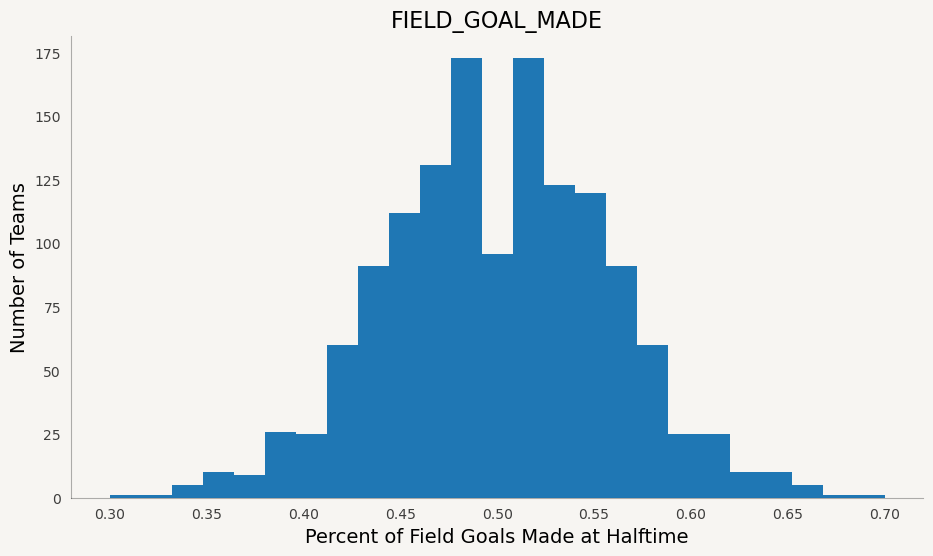

In [27]:

# See if features are Normal
for feature in df_gaussian.keys():
    fig, ax = plt.subplots(figsize=figsize)
    fig.set_facecolor(facecolor)
    ax.set_facecolor(facecolor)
    hist = ax.hist(df_gaussian[feature], bins=25)
    tidy_axes(ax)
    ax.set_title(feature, fontsize=titlesize)
    ax.set_xlabel("Percent of Field Goals Made at Halftime", fontsize=labelsize)
    ax.set_ylabel("Number of Teams", fontsize=labelsize)
    print(np.sum(hist[0]))
    plt.savefig("../images/module3_images/histogram_field_goal_made.png")
    plt.show()
    
    break

In [42]:
# This cell verifies that for every percentange goal, there's 1-percentage
value_counts = df_gaussian["FIELD_GOAL_MADE"].value_counts()
percents = value_counts.index

for percent in percents:
    
    oppPercentActual = 1 - percent
    minimizedIndex = np.argmin(np.abs(value_counts.index - oppPercentActual))
    oppPercent = value_counts.index[minimizedIndex]
    
#     print(f"{percent}...{value_counts[percent]}")
#     print(f"{oppPercent}...{value_counts[oppPercent]}")
#     print(oppPercent+percent)
    
#     print()
    

In [533]:
# Test train split on percents_df
y = df["WL"].map({"W":1, "L":0}).values
X = df_gaussian.values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [534]:
# Train and test model
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


Accuracy is: 0.7111913357400722
Error rate is 0.2888086642599278


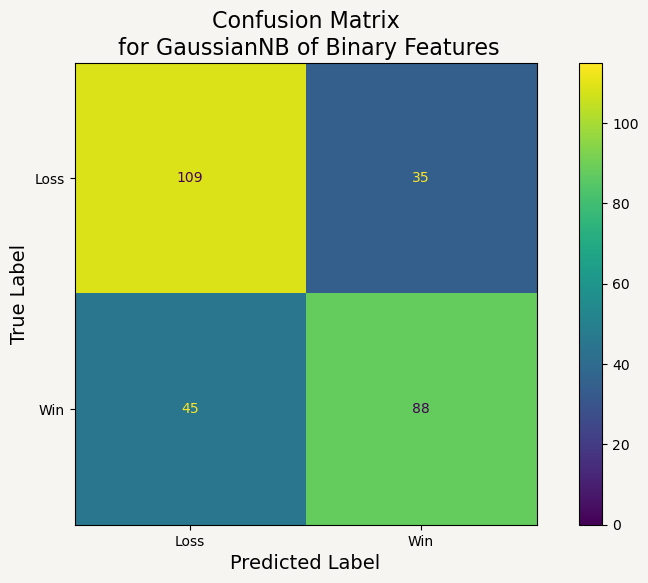

In [536]:
# Confusion matrix
fig, ax = plt.subplots(figsize=figsize)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Loss", "Win"])
disp.plot(ax=ax)

acc = np.diagonal(cm).sum()/np.sum(cm)
err = 1 - acc

im = ax.images[0]
im.set_clim(vmin=0, vmax=115)
fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)
ax.set_xlabel("Predicted Label", fontsize=labelsize)
ax.set_ylabel("True Label", fontsize=labelsize)
ax.set_title("Confusion Matrix\n for GaussianNB of Binary Features", fontsize=titlesize)
plt.savefig("../images/module3_images/confusion_matrix_gaussianNB.png")

print()
print(f"Accuracy is: {acc}")
print(f"Error rate is {err}")

___
## DECISION TREE TAB
### Here I'll use 3 different subsets of data to visualize 3 different trees
* #### the DIFF labels
* #### without DIFF labels
* #### all data

In [537]:
# DIFF only features
df_tree_diff = df[["FIELD_GOAL_MADE_DIFF", "FIELD_GOAL_MISSED_DIFF", "REBOUND_DIFF", "WL"]]# df_unlabeled.copy()
df_tree_diff = df_tree_diff.head(20)

In [538]:
# Test train split on df_tree
y_tree_diff = df_tree_diff["WL"].map({"W":1, "L":0}).values
X = df_tree_diff.drop(columns=["WL"]).values
X_train, X_test, y_train, y_test = train_test_split(X, y_tree_diff, train_size=0.8)

In [539]:
# Train and test model
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


Accuracy is: 0.5
Error rate is 0.5


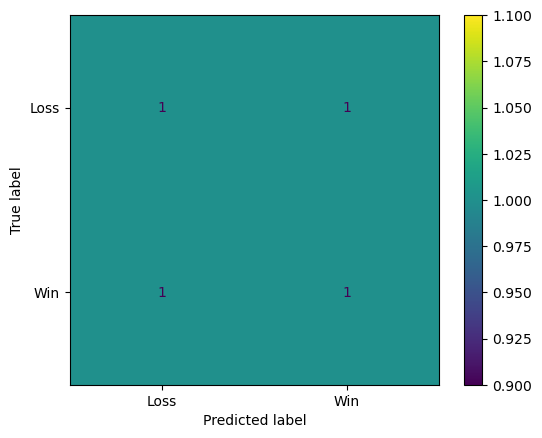

In [540]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Loss", "Win"])
disp.plot()

acc = np.diagonal(cm).sum()/np.sum(cm)
err = 1 - acc

print()
print(f"Accuracy is: {acc}")
print(f"Error rate is {err}")

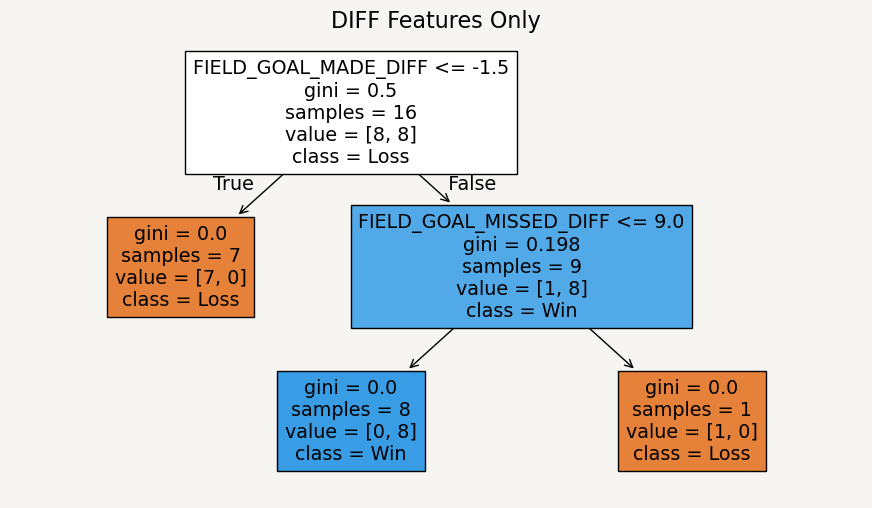

In [541]:
fig, ax = plt.subplots(figsize=figsize)
plot_tree(clf, 
          feature_names=df_tree_diff.drop(columns=["WL"]).columns, 
          class_names=["Loss", "Win"], filled=True,
          ax=ax);

fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)
ax.set_title("DIFF Features Only", fontsize=titlesize)
plt.savefig("../images/module3_images/diff_tree.png")
plt.show()

In [542]:
# No DIFF features
df_tree_no_diff = df[[col for col in df.keys() if "DIFF" not in col]]# df_unlabeled.copy()
df_tree_no_diff = df_tree_no_diff.drop(columns=["TEAM_NAME"])
df_tree_no_diff = df_tree_no_diff.head(20)

In [543]:
# Test train split on df_tree
y_tree_no_diff = df_tree_no_diff["WL"].map({"W":1, "L":0}).values
X = df_tree_no_diff.drop(columns=["WL"]).values
X_train, X_test, y_train, y_test = train_test_split(X, y_tree_no_diff, train_size=0.8)

In [544]:
# Train and test model
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


Accuracy is: 0.5
Error rate is 0.5


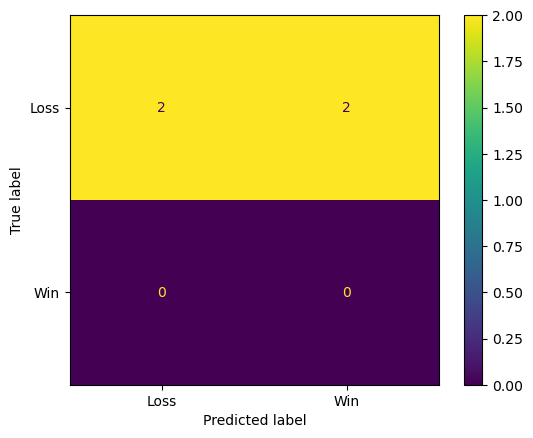

In [545]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Loss", "Win"])
disp.plot()

acc = np.diagonal(cm).sum()/np.sum(cm)
err = 1 - acc

print()
print(f"Accuracy is: {acc}")
print(f"Error rate is {err}")

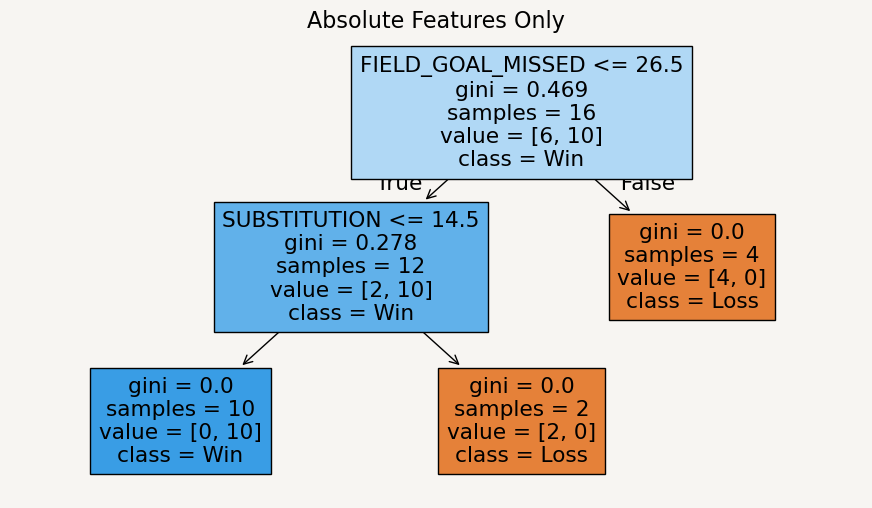

In [546]:
fig, ax = plt.subplots(figsize=figsize)
plot_tree(clf, 
          feature_names=df_tree_no_diff.drop(columns=["WL"]).columns, 
          class_names=["Loss", "Win"], filled=True,
          ax=ax);

fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)
ax.set_title("Absolute Features Only", fontsize=titlesize)
plt.savefig("../images/module3_images/no_diff_tree.png")
plt.show()

In [547]:
# All features. Absolute and DIFF
df_tree= df.drop(columns=["GAME_ID", "TEAM_NAME"])
df_tree = df_tree.head(20)

In [548]:
# Test train split on df_tree
y_tree = df_tree["WL"].map({"W":1, "L":0}).values
X = df_tree.drop(columns=["WL"]).values
X_train, X_test, y_train, y_test = train_test_split(X, y_tree, train_size=0.8)

In [549]:
# Train and test model
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


Accuracy is: 0.5
Error rate is 0.5


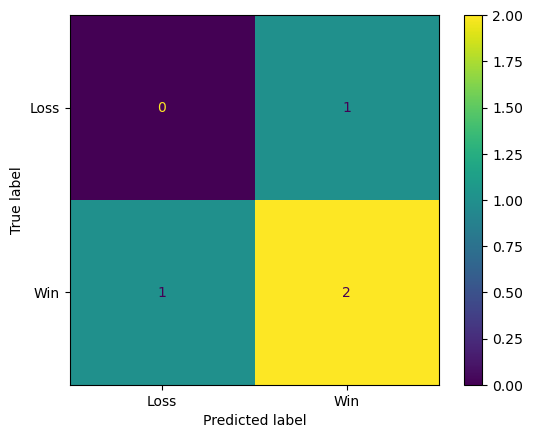

In [550]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Loss", "Win"])
disp.plot()

acc = np.diagonal(cm).sum()/np.sum(cm)
err = 1 - acc

print()
print(f"Accuracy is: {acc}")
print(f"Error rate is {err}")

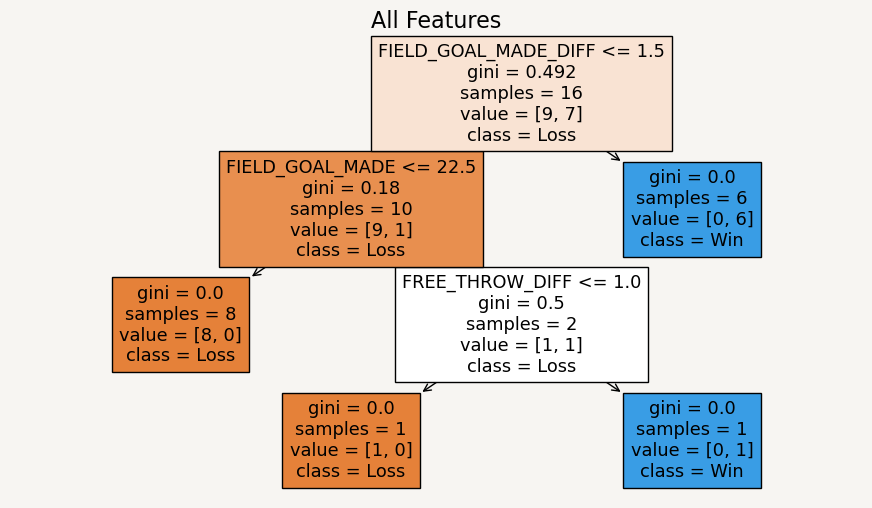

In [551]:
fig, ax = plt.subplots(figsize=figsize)
plot_tree(clf, 
          feature_names=df_tree.columns, 
          class_names=["Loss", "Win"], filled=True,
          ax=ax);

fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)

ax.set_title("All Features", fontsize=titlesize)
plt.savefig("../images/module3_images/all_features_tree.png")
plt.show()

### Peform simulation on 3 types of trees and compare accuracy

In [552]:
# Now perform a simulation on 3 different types of trees
df_tree_diff = df[["FIELD_GOAL_MADE_DIFF", "FIELD_GOAL_MISSED_DIFF", "REBOUND_DIFF"]]
df_tree_no_diff = df[[col for col in df.keys() if "DIFF" not in col]].drop(columns=["TEAM_NAME", "GAME_ID", "WL"])
df_tree = df.drop(columns=["GAME_ID", "TEAM_NAME", "WL"])

df_tree_diff.info()
print()
df_tree_no_diff.info()
print()
df_tree.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1384 entries, 0 to 1383
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   FIELD_GOAL_MADE_DIFF    1384 non-null   int64
 1   FIELD_GOAL_MISSED_DIFF  1384 non-null   int64
 2   REBOUND_DIFF            1384 non-null   int64
dtypes: int64(3)
memory usage: 75.5 KB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1384 entries, 0 to 1383
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   FIELD_GOAL_MADE    1384 non-null   int64
 1   FIELD_GOAL_MISSED  1384 non-null   int64
 2   FREE_THROW         1384 non-null   int64
 3   REBOUND            1384 non-null   int64
 4   TURNOVER           1384 non-null   int64
 5   FOUL               1384 non-null   int64
 6   VIOLATION          1384 non-null   int64
 7   SUBSTITUTION       1384 non-null   int64
 8   EJECTION           1384 non-

In [553]:
tree_dict = {"all_data":
                   {"df": df_tree,
                    "acc": []}, 
               
               "diff":
                   {"df": df_tree_diff,
                    "acc": []}, 
               
               "no_diff":
                   {"df": df_tree_no_diff,
                    "acc": []}
              }
for _ in range(500):
    
    # Manually get indices for training and testing
    numToTrain = round(0.80*len(df))
    trainIndices = np.random.choice(df.index, size=numToTrain, replace=False)
    trainMask = np.isin(df.index, trainIndices)
    testIndices = df.index[~trainMask]
    
    for tree_type in tree_dict.keys():
        
        tree_df = tree_dict[tree_type]["df"]
        accuracy_list = tree_dict[tree_type]["acc"]
        
        # Split data into training and testing
        X_train = tree_df.loc[trainIndices]
        y_train = df["WL"].loc[trainIndices]
        X_test = tree_df.loc[testIndices]
        y_test = df["WL"].loc[testIndices]

        # Fit and predit with DIFF data. Calculate and save accuracy.
        clf = DecisionTreeClassifier()
        clf.fit(X_train, y_train)
        
        y_pred = clf.predict(X_test)

        accuracy_list.append(accuracy_score(y_test, y_pred))
        


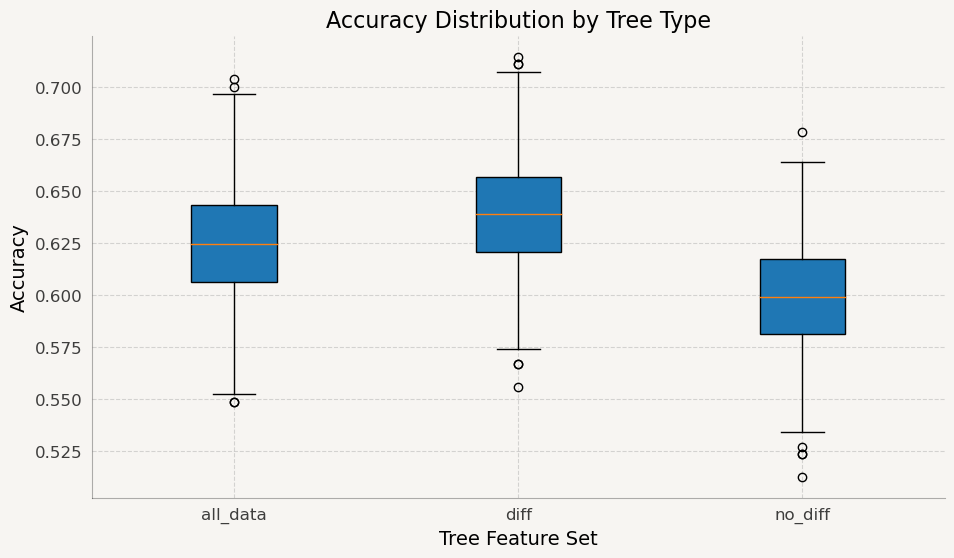

In [554]:
# Gather results
labels = []
acc_data = []

for tree_type in tree_dict:
    labels.append(tree_type)
    acc_data.append(tree_dict[tree_type]["acc"])

# Create boxplot
fig, ax = plt.subplots(figsize=figsize)
ax.boxplot(acc_data, labels=labels, patch_artist=True)

# Design
ax.set_title("Accuracy Distribution by Tree Type", fontsize=titlesize)
ax.set_ylabel("Accuracy", fontsize=labelsize)
ax.set_xlabel("Tree Feature Set", fontsize=labelsize)
ax.grid(True, linestyle="--", alpha=0.5)
fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)
plt.xticks(fontsize=12,)
plt.yticks(fontsize=12)
tidy_axes(ax)
plt.savefig("../images/module3_images/box_plot_tree_sim.png")
plt.show()

## Conclusion and simulation